In [ ]:
# use TensorFlow decision forests to predict customer churn

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
import math

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import tensorflow_decision_forests as tfdf

import matplotlib.pyplot as plt

##### helper functions

In [3]:
def trainRandomForest(tf_dataset, n_trees, max_depth):
    
    model = tfdf.keras.RandomForestModel(num_trees = n_trees, max_depth = max_depth, verbose = 0, 
                                        compute_oob_variable_importances = True)
    
    model.fit(tf_dataset)
    
    return model

def trainGBTModel(tf_dataset, tf_validation_data, n_trees, max_depth):

    model_gbt = tfdf.keras.GradientBoostedTreesModel(features = all_features, 
                                                     exclude_non_specified_features = True, 
                                                     num_trees = n_trees, 
                                                     max_depth = max_depth, 
                                                     compute_permutation_variable_importance = True, 
                                                     verbose = 0)
    
    model_gbt.fit(tf_dataset, validation_data = tf_validation_data)
    
    return model_gbt


def computeMetrics(model, val_dataset, label):
 
    # evaluate the model
    evaluation = model.predict(val_dataset)

    # predicted probabilities of subscription renewal
    predicted_probs = evaluation.flatten()


    predictions = (predicted_probs > 0.5).astype(int)
    
    metrics = {
        "accuracy": accuracy_score(val_ds_pd[label], predictions),
        "precision": precision_score(val_ds_pd[label], predictions),
        "recall": recall_score(val_ds_pd[label], predictions),
        "f1": f1_score(val_ds_pd[label], predictions),
        "roc_auc": roc_auc_score(val_ds_pd[label], predictions),
    }
    
    return metrics


##### load dataset

In [4]:
# load dataset
dataset = pd.read_csv("dataset.csv", low_memory = False)

# dataset.shape

print("{} examples, and {} features in the dataset".format(
    dataset.shape[0], dataset.shape[1]))

413955 examples, and 37 features in the dataset


In [5]:
dataset.columns

Index(['subscription_id', 'observation_dt', 'is_retained', 'specialization_id',
       'cnt_courses_in_specialization', 'specialization_domain',
       'is_professional_certificate', 'is_gateway_certificate',
       'learner_days_since_registration', 'learner_country_group',
       'learner_gender', 'learner_cnt_other_courses_active',
       'learner_cnt_other_courses_paid_active',
       'learner_cnt_other_courses_items_completed',
       'learner_cnt_other_courses_paid_items_completed',
       'learner_cnt_other_transactions_past', 'learner_other_revenue',
       'subscription_period_order', 'days_since_last_payment',
       'days_til_next_payment_due',
       'cnt_enrollments_started_before_payment_period',
       'cnt_enrollments_completed_before_payment_period',
       'cnt_enrollments_active_before_payment_period',
       'cnt_items_completed_before_payment_period',
       'cnt_graded_items_completed_before_payment_period',
       'is_subscription_started_with_free_trial',
      

In [6]:
# remove NA values
dataset = dataset.dropna()
sum(dataset.isnull().sum())

0

In [7]:
# drop id and time features
drop_features = ["subscription_id", "observation_dt", "specialization_id"]

dataset = dataset.drop(columns = drop_features)

In [8]:
dataset.dtypes

is_retained                                         float64
cnt_courses_in_specialization                       float64
specialization_domain                                object
is_professional_certificate                          object
is_gateway_certificate                               object
learner_days_since_registration                     float64
learner_country_group                                object
learner_gender                                       object
learner_cnt_other_courses_active                    float64
learner_cnt_other_courses_paid_active               float64
learner_cnt_other_courses_items_completed           float64
learner_cnt_other_courses_paid_items_completed      float64
learner_cnt_other_transactions_past                 float64
learner_other_revenue                               float64
subscription_period_order                           float64
days_since_last_payment                             float64
days_til_next_payment_due               

In [9]:
# transform boolean columns into string type

bool_cols = ["is_professional_certificate", "is_gateway_certificate", "is_active_capstone_during_pay_period", 
             "is_subscription_started_with_free_trial", "is_active_capstone_during_pay_period"]

for column in bool_cols:
#     print(column)
    dataset[column] = dataset[column].astype(str)

In [10]:
dataset["is_retained"] = dataset["is_retained"].astype(int)

In [11]:
# balanced dataset?
# what percent of the data represents the positive class

sum(dataset["is_retained"]) / dataset.shape[0] * 100

54.36631694902562

### Random Forest model

In [12]:
# split dataset into training, validation and test sets

random_state = 1234

label = "is_retained"

train_ds_pd, val_ds_pd = train_test_split(dataset, test_size = 0.4, random_state = random_state)
val_ds_pd, test_ds_pd = train_test_split(val_ds_pd, test_size = 0.5, random_state = random_state)

In [13]:
print("{} examples in training, {} examples for validation, {} examples for testing.".format(
    train_ds_pd.shape[0], val_ds_pd.shape[0], test_ds_pd.shape[0]))

248371 examples in training, 82791 examples for validation, 82791 examples for testing.


In [14]:
# convert the pandas dataframe into tensorflow datasets

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

#### train and evaluate the model

In [ ]:
trees = range(50, 1050, 50)

accuracy = []
precision = []
recall = []
f1 = []
roc_auc = []

In [22]:

for tree in trees:
    
    model = trainRandomForest(train_ds, tree, max_depth = 16)
    
    print("trained forest with {} trees".format(tree))
    
    metrics = computeMetrics(model, val_ds, label)
    
    accuracy.append((tree, metrics["accuracy"]))
    precision.append((tree, metrics["precision"]))
    recall.append((tree, metrics["recall"]))
    f1.append((tree, metrics["f1"]))
    roc_auc.append((tree, metrics["roc_auc"]))
    
    

[INFO 24-04-30 15:07:20.1359 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmphxz4uvb0/model/ with prefix ab026115bd7f4d64
[INFO 24-04-30 15:07:21.4079 EDT decision_forest.cc:734] Model loaded with 50 root(s), 517174 node(s), and 33 input feature(s).
[INFO 24-04-30 15:07:21.4080 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:07:21.4080 EDT kernel.cc:1061] Use fast generic engine


trained forest with 50 trees
83/83 [==============================] - 2s 27ms/step


[INFO 24-04-30 15:10:57.3742 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpq3qa1s4a/model/ with prefix 46fb34ca8a5f427c
[INFO 24-04-30 15:11:00.0984 EDT decision_forest.cc:734] Model loaded with 100 root(s), 1042346 node(s), and 33 input feature(s).
[INFO 24-04-30 15:11:00.0984 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:11:00.0984 EDT kernel.cc:1061] Use fast generic engine


trained forest with 100 trees
83/83 [==============================] - 2s 27ms/step


[INFO 24-04-30 15:16:26.9185 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpa4eh7itr/model/ with prefix 50f70013aa0f4a2c
[INFO 24-04-30 15:16:30.6605 EDT decision_forest.cc:734] Model loaded with 150 root(s), 1558600 node(s), and 33 input feature(s).
[INFO 24-04-30 15:16:30.6605 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:16:30.6606 EDT kernel.cc:1061] Use fast generic engine


trained forest with 150 trees
83/83 [==============================] - 3s 34ms/step


[INFO 24-04-30 15:23:29.2653 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpc31qfeqk/model/ with prefix 4fb8d70708a4428f
[INFO 24-04-30 15:23:34.2165 EDT decision_forest.cc:734] Model loaded with 200 root(s), 2066842 node(s), and 33 input feature(s).
[INFO 24-04-30 15:23:34.2165 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:23:34.2166 EDT kernel.cc:1061] Use fast generic engine


trained forest with 200 trees
83/83 [==============================] - 4s 50ms/step


[INFO 24-04-30 15:31:57.9592 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmplmvvcb7p/model/ with prefix c27f26216e7e47e2
[INFO 24-04-30 15:32:04.1361 EDT decision_forest.cc:734] Model loaded with 250 root(s), 2585618 node(s), and 33 input feature(s).
[INFO 24-04-30 15:32:04.1361 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:32:04.1361 EDT kernel.cc:1061] Use fast generic engine


trained forest with 250 trees
83/83 [==============================] - 5s 63ms/step


[INFO 24-04-30 15:42:02.9768 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpeqaadnyc/model/ with prefix b9ca8d2931334de6
[INFO 24-04-30 15:42:10.2846 EDT decision_forest.cc:734] Model loaded with 300 root(s), 3115072 node(s), and 33 input feature(s).
[INFO 24-04-30 15:42:10.2847 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:42:10.2847 EDT kernel.cc:1061] Use fast generic engine


trained forest with 300 trees
83/83 [==============================] - 7s 85ms/step


[INFO 24-04-30 15:53:43.1877 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpo0ee3p97/model/ with prefix 66666ae2e253422b
[INFO 24-04-30 15:53:51.7516 EDT decision_forest.cc:734] Model loaded with 350 root(s), 3628918 node(s), and 33 input feature(s).
[INFO 24-04-30 15:53:51.7516 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:53:51.7516 EDT kernel.cc:1061] Use fast generic engine


trained forest with 350 trees
83/83 [==============================] - 9s 102ms/step


[INFO 24-04-30 16:06:51.6703 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpm6dyp8dr/model/ with prefix abbec12c7b764df1
[INFO 24-04-30 16:07:01.5865 EDT decision_forest.cc:734] Model loaded with 400 root(s), 4148506 node(s), and 33 input feature(s).
[INFO 24-04-30 16:07:01.5866 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 16:07:01.5866 EDT kernel.cc:1061] Use fast generic engine


trained forest with 400 trees
83/83 [==============================] - 8s 101ms/step


[INFO 24-04-30 16:21:27.0989 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp9etog2aq/model/ with prefix a5866d76733f4838
[INFO 24-04-30 16:21:38.2219 EDT decision_forest.cc:734] Model loaded with 450 root(s), 4673788 node(s), and 33 input feature(s).
[INFO 24-04-30 16:21:38.2220 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 16:21:38.2220 EDT kernel.cc:1061] Use fast generic engine


trained forest with 450 trees
83/83 [==============================] - 9s 111ms/step


[INFO 24-04-30 16:37:42.7087 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp3uu2o7hr/model/ with prefix 5b8fc906c4dc4876
[INFO 24-04-30 16:37:55.0515 EDT decision_forest.cc:734] Model loaded with 500 root(s), 5193590 node(s), and 33 input feature(s).
[INFO 24-04-30 16:37:55.0515 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 16:37:55.0516 EDT kernel.cc:1061] Use fast generic engine


trained forest with 500 trees
83/83 [==============================] - 10s 123ms/step


[INFO 24-04-30 16:55:53.6634 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpdhs83sbp/model/ with prefix 11c36a4b728a414b
[INFO 24-04-30 16:56:07.3733 EDT decision_forest.cc:734] Model loaded with 550 root(s), 5707908 node(s), and 33 input feature(s).
[INFO 24-04-30 16:56:07.3733 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 16:56:07.3734 EDT kernel.cc:1061] Use fast generic engine


trained forest with 550 trees
83/83 [==============================] - 13s 156ms/step


[INFO 24-04-30 17:15:52.2992 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpxrb7dsao/model/ with prefix 06259be5f2404c88
[INFO 24-04-30 17:16:07.3958 EDT decision_forest.cc:734] Model loaded with 600 root(s), 6231280 node(s), and 33 input feature(s).
[INFO 24-04-30 17:16:07.3958 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 17:16:07.3959 EDT kernel.cc:1061] Use fast generic engine


trained forest with 600 trees
83/83 [==============================] - 14s 164ms/step


[INFO 24-04-30 17:37:31.3680 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp4vg8rvvd/model/ with prefix 4053541e0bbd45f7
[INFO 24-04-30 17:37:47.9073 EDT decision_forest.cc:734] Model loaded with 650 root(s), 6753718 node(s), and 33 input feature(s).
[INFO 24-04-30 17:37:47.9073 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 17:37:47.9074 EDT kernel.cc:1061] Use fast generic engine


trained forest with 650 trees
83/83 [==============================] - 15s 185ms/step


[INFO 24-04-30 18:00:35.3021 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp0jx9zaph/model/ with prefix 37354aaca34c4083
[INFO 24-04-30 18:00:53.2853 EDT decision_forest.cc:734] Model loaded with 700 root(s), 7276770 node(s), and 33 input feature(s).
[INFO 24-04-30 18:00:53.2853 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 18:00:53.2854 EDT kernel.cc:1061] Use fast generic engine


trained forest with 700 trees
83/83 [==============================] - 16s 189ms/step


[INFO 24-04-30 18:25:14.1814 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp3nbiuj7i/model/ with prefix 25d9b80d7cf4498e
[INFO 24-04-30 18:25:33.0408 EDT decision_forest.cc:734] Model loaded with 750 root(s), 7799354 node(s), and 33 input feature(s).
[INFO 24-04-30 18:25:33.0409 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 18:25:33.0409 EDT kernel.cc:1061] Use fast generic engine


trained forest with 750 trees
83/83 [==============================] - 17s 208ms/step


[INFO 24-04-30 18:51:46.4273 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp4bkxm1d0/model/ with prefix d36e172d410348aa
[INFO 24-04-30 18:52:06.6836 EDT decision_forest.cc:734] Model loaded with 800 root(s), 8319112 node(s), and 33 input feature(s).
[INFO 24-04-30 18:52:06.6837 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 18:52:06.6837 EDT kernel.cc:1061] Use fast generic engine


trained forest with 800 trees
83/83 [==============================] - 19s 231ms/step


[INFO 24-04-30 19:19:45.9985 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp7rb3u7z3/model/ with prefix 1f90ca3bb38a40eb
[INFO 24-04-30 19:20:07.6590 EDT decision_forest.cc:734] Model loaded with 850 root(s), 8845822 node(s), and 33 input feature(s).
[INFO 24-04-30 19:20:07.6590 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 19:20:07.6590 EDT kernel.cc:1061] Use fast generic engine


trained forest with 850 trees
83/83 [==============================] - 19s 233ms/step


[INFO 24-04-30 19:49:04.5678 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp77r9g15f/model/ with prefix 1e0eebc76e4b4ca7
[INFO 24-04-30 19:49:27.0945 EDT decision_forest.cc:734] Model loaded with 900 root(s), 9366382 node(s), and 33 input feature(s).
[INFO 24-04-30 19:49:27.0946 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 19:49:27.0946 EDT kernel.cc:1061] Use fast generic engine


trained forest with 900 trees
83/83 [==============================] - 21s 252ms/step


[INFO 24-04-30 20:20:28.8070 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpwws0n7xb/model/ with prefix 24fc01dea48748d5
[INFO 24-04-30 20:20:52.8674 EDT decision_forest.cc:734] Model loaded with 950 root(s), 9882462 node(s), and 33 input feature(s).
[INFO 24-04-30 20:20:52.8675 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 20:20:52.8675 EDT kernel.cc:1061] Use fast generic engine


trained forest with 950 trees
83/83 [==============================] - 23s 271ms/step


[INFO 24-04-30 20:53:39.0444 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmplcs_4peg/model/ with prefix 6c74189be58a4cb1
[INFO 24-04-30 20:54:04.3262 EDT decision_forest.cc:734] Model loaded with 1000 root(s), 10398788 node(s), and 33 input feature(s).
[INFO 24-04-30 20:54:04.3262 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 20:54:04.3263 EDT kernel.cc:1061] Use fast generic engine


trained forest with 1000 trees
83/83 [==============================] - 25s 299ms/step


In [44]:
accuracy_plot = [a for _, a in accuracy]
precision_plot = [a for _, a in precision]
recall_plot = [a for _, a in recall]
f1_plot = [a for _, a in f1]
roc_auc_plot = [a for _, a in roc_auc]

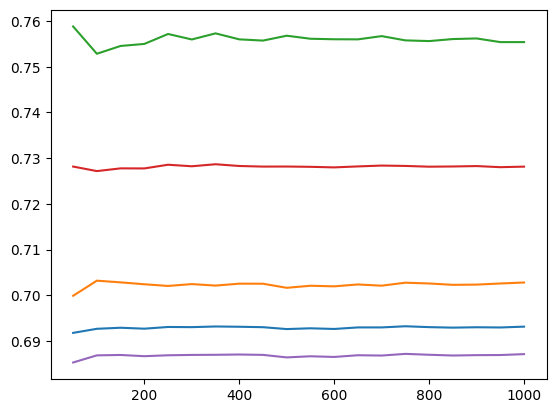

In [45]:
plt.plot(trees, accuracy_plot)
plt.plot(trees, precision_plot)
plt.plot(trees, recall_plot)
plt.plot(trees, f1_plot)
plt.plot(trees, roc_auc_plot)

plt.show()

In [24]:
model.summary()

Model: "random_forest_model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (33):
	cnt_courses_in_specialization
	cnt_days_active_before_payment_period
	cnt_days_active_during_payment_period
	cnt_days_since_last_activity
	cnt_enrollments_active_before_payment_period
	cnt_enrollments_active_during_payment_period
	cnt_enrollments_completed_before_payment_period
	cnt_enrollments_completed_during_payment_period
	cnt_enrollments_started_before_payment_period
	cnt_enrollments_started_during_payment_period
	cnt_graded_items_completed_before_payment_period
	cnt_graded_items_completed_during_payment_period
	cnt_items_completed_before_payment_period
	cnt_items_completed_durin

In [47]:
metrics = {
    "trees": [a for a, _ in accuracy],
    "accuracy": [a for _, a in accuracy],
    "precision": [a for _, a in precision],
    "recall": [a for _, a in recall],
    "f1": [a for _, a in f1],
    "roc_auc": [a for _, a in roc_auc],
}

In [52]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,trees,accuracy,precision,recall,f1,roc_auc
0,50,0.691766,0.699887,0.758825,0.728166,0.685288
1,100,0.692660,0.703191,0.752853,0.727175,0.686845
2,150,0.692889,0.702821,0.754562,0.727773,0.686932
3,200,0.692684,0.702406,0.755006,0.727757,0.686664
4,250,0.693058,0.702038,0.757182,0.728568,0.686864
5,300,0.693022,0.702445,0.755983,0.728231,0.686940
6,350,0.693167,0.702118,0.757315,0.728673,0.686971
7,400,0.693107,0.702538,0.756006,0.728292,0.687031
8,450,0.693010,0.702522,0.755739,0.728159,0.686951
9,500,0.692599,0.701630,0.756805,0.728174,0.686397


In [53]:
metrics_df.to_csv("prediction_data/rf_ntrees_test.csv", index = False)

### Gradient Boosted Trees model

In [62]:
max_depth = range(1, 31, 1)

accuracy = []
precision = []
recall = []
f1 = []
roc_auc = []

In [65]:
# trainGBTModel(tf_dataset, tf_validation_data, n_trees, max_depth)

for depth in max_depth:
    
    model = trainGBTModel(train_ds, val_ds, n_trees = 300, max_depth = depth)
    
    print("trained forest with max_depth of {}".format(depth))
    
    metrics = computeMetrics(model, val_ds, label)
    
    accuracy.append((depth, metrics["accuracy"]))
    precision.append((depth, metrics["precision"]))
    recall.append((depth, metrics["recall"]))
    f1.append((depth, metrics["f1"]))
    roc_auc.append((depth, metrics["roc_auc"]))

[WARNING 24-05-01 12:15:50.5609 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:15:50.5610 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:15:50.5610 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:15:59.7089 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpke7xibzc/model/ with prefix f05470475d034df9
[INFO 24-05-01 12:15:59.7102 EDT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[WARNING 24-05-01 12:15:59.7102 EDT utils.cc:73] The model does not have any input features i.e. the model is constant and will always return the same prediction.
[INFO 24-05-01 12:15:59.7103 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-01 12:15:59.7103 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 1
83/83 [==============================] - 2s 26ms/step


[WARNING 24-05-01 12:16:05.2825 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:16:05.2826 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:16:05.2826 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:16:33.2310 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpx1bblz90/model/ with prefix 7e03044becde4418
[INFO 24-05-01 12:16:33.2337 EDT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-05-01 12:16:33.2340 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-01 12:16:33.2341 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 2
83/83 [==============================] - 4s 50ms/step


[WARNING 24-05-01 12:16:40.7560 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:16:40.7561 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:16:40.7561 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:17:19.7566 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpgermyfbh/model/ with prefix f1a6e9d3df534650
[INFO 24-05-01 12:17:19.7621 EDT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-05-01 12:17:19.7625 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-01 12:17:19.7625 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 3
83/83 [==============================] - 4s 42ms/step


[WARNING 24-05-01 12:17:26.1218 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:17:26.1218 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:17:26.1218 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:18:14.3950 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpbs8iw1n7/model/ with prefix f7b5d61a727e4e8b
[INFO 24-05-01 12:18:14.4049 EDT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-05-01 12:18:14.4055 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-01 12:18:14.4055 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 4
83/83 [==============================] - 3s 30ms/step


[WARNING 24-05-01 12:18:19.4660 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:18:19.4661 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:18:19.4661 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:19:22.8159 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpbp4kwhua/model/ with prefix 7a059f6ddfa44bbe
[INFO 24-05-01 12:19:22.8351 EDT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-05-01 12:19:22.8360 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-01 12:19:22.8361 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 5
83/83 [==============================] - 2s 25ms/step


[WARNING 24-05-01 12:19:27.9114 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:19:27.9115 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:19:27.9115 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:20:41.5563 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpsv4a1dyf/model/ with prefix e958f9d60c58477b
[INFO 24-05-01 12:20:41.5897 EDT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-05-01 12:20:41.5916 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-01 12:20:41.5916 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 6
83/83 [==============================] - 2s 22ms/step


[WARNING 24-05-01 12:20:46.1375 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:20:46.1375 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:20:46.1375 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:22:00.0579 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpluge5dgv/model/ with prefix 4469d1d56a4847af
[INFO 24-05-01 12:22:00.1068 EDT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-05-01 12:22:00.1090 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-01 12:22:00.1090 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 7
83/83 [==============================] - 2s 24ms/step


[WARNING 24-05-01 12:22:04.8744 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:22:04.8745 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:22:04.8745 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:23:17.6049 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpxqsf3r6b/model/ with prefix 9ba0c61308b84b48
[INFO 24-05-01 12:23:17.6759 EDT decision_forest.cc:734] Model loaded with 175 root(s), 32671 node(s), and 33 input feature(s).
[INFO 24-05-01 12:23:17.6759 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:23:17.6760 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 8
83/83 [==============================] - 2s 27ms/step


[WARNING 24-05-01 12:23:23.1099 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:23:23.1100 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:23:23.1100 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:24:34.2798 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpgg86v0es/model/ with prefix 5548fba84b6747ca
[INFO 24-05-01 12:24:34.3824 EDT decision_forest.cc:734] Model loaded with 140 root(s), 46782 node(s), and 33 input feature(s).
[INFO 24-05-01 12:24:34.3825 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:24:34.3825 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 9
83/83 [==============================] - 2s 25ms/step


[WARNING 24-05-01 12:24:39.0892 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:24:39.0892 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:24:39.0893 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:25:41.7121 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp_z4fhg7j/model/ with prefix 620c56ec4282484c
[INFO 24-05-01 12:25:41.8427 EDT decision_forest.cc:734] Model loaded with 89 root(s), 58005 node(s), and 33 input feature(s).
[INFO 24-05-01 12:25:41.8428 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:25:41.8428 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 10
83/83 [==============================] - 2s 25ms/step


[WARNING 24-05-01 12:25:46.4831 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:25:46.4832 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:25:46.4832 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:26:59.6756 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp_sdp_cco/model/ with prefix 9b297ce223bb47ab
[INFO 24-05-01 12:26:59.8892 EDT decision_forest.cc:734] Model loaded with 87 root(s), 94951 node(s), and 33 input feature(s).
[INFO 24-05-01 12:26:59.8892 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:26:59.8893 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 11
83/83 [==============================] - 2s 25ms/step


[WARNING 24-05-01 12:27:04.6177 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:27:04.6178 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:27:04.6178 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:28:21.0167 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpjklr671n/model/ with prefix c973d7eb6ab44ab6
[INFO 24-05-01 12:28:21.3213 EDT decision_forest.cc:734] Model loaded with 67 root(s), 134519 node(s), and 33 input feature(s).
[INFO 24-05-01 12:28:21.3213 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:28:21.3213 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 12
83/83 [==============================] - 2s 25ms/step


[WARNING 24-05-01 12:28:25.9895 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:28:25.9896 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:28:25.9896 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:29:49.7685 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpxo70r7ao/model/ with prefix 97de82b6701b4502
[INFO 24-05-01 12:29:50.1905 EDT decision_forest.cc:734] Model loaded with 53 root(s), 184083 node(s), and 33 input feature(s).
[INFO 24-05-01 12:29:50.1906 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:29:50.1906 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 13
83/83 [==============================] - 2s 24ms/step


[WARNING 24-05-01 12:29:54.8967 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:29:54.8968 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:29:54.8968 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:31:24.5290 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpnjq30q1o/model/ with prefix a9c2c88c922a498f
[INFO 24-05-01 12:31:25.0396 EDT decision_forest.cc:734] Model loaded with 39 root(s), 225759 node(s), and 33 input feature(s).
[INFO 24-05-01 12:31:25.0396 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:31:25.0396 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 14
83/83 [==============================] - 2s 25ms/step


[WARNING 24-05-01 12:31:29.7454 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:31:29.7454 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:31:29.7454 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:33:19.6706 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmphvlah_8x/model/ with prefix 8a66679f83164d5e
[INFO 24-05-01 12:33:20.3363 EDT decision_forest.cc:734] Model loaded with 34 root(s), 298848 node(s), and 33 input feature(s).
[INFO 24-05-01 12:33:20.3363 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:33:20.3363 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 15
83/83 [==============================] - 2s 22ms/step


[WARNING 24-05-01 12:33:24.8803 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:33:24.8804 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:33:24.8804 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:35:35.6557 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpvww2o1xp/model/ with prefix 12b44c5043fa4b37
[INFO 24-05-01 12:35:36.4807 EDT decision_forest.cc:734] Model loaded with 29 root(s), 369813 node(s), and 33 input feature(s).
[INFO 24-05-01 12:35:36.4808 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:35:36.4808 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 16
83/83 [==============================] - 2s 22ms/step


[WARNING 24-05-01 12:35:40.9901 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:35:40.9901 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:35:40.9902 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:38:15.7197 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpj5aoiyf7/model/ with prefix 7717c76d13254e48
[INFO 24-05-01 12:38:16.6754 EDT decision_forest.cc:734] Model loaded with 24 root(s), 422264 node(s), and 33 input feature(s).
[INFO 24-05-01 12:38:16.6754 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:38:16.6755 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 17
83/83 [==============================] - 2s 23ms/step


[WARNING 24-05-01 12:38:21.2795 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:38:21.2796 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:38:21.2796 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:41:23.4616 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpv8qhywi1/model/ with prefix d1832db093bf4c66
[INFO 24-05-01 12:41:24.5065 EDT decision_forest.cc:734] Model loaded with 21 root(s), 466713 node(s), and 33 input feature(s).
[INFO 24-05-01 12:41:24.5066 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:41:24.5066 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 18
83/83 [==============================] - 2s 22ms/step


[WARNING 24-05-01 12:41:29.0877 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:41:29.0877 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:41:29.0878 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:45:17.6394 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmprdqfwcrj/model/ with prefix e3dea52e987048c3
[INFO 24-05-01 12:45:18.8754 EDT decision_forest.cc:734] Model loaded with 20 root(s), 559922 node(s), and 33 input feature(s).
[INFO 24-05-01 12:45:18.8754 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:45:18.8755 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 19
83/83 [==============================] - 2s 23ms/step


[WARNING 24-05-01 12:45:23.5741 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:45:23.5741 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:45:23.5741 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:49:47.0659 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpylvyuxjc/model/ with prefix fc8dee8f9ada47bf
[INFO 24-05-01 12:49:48.3891 EDT decision_forest.cc:734] Model loaded with 18 root(s), 598422 node(s), and 33 input feature(s).
[INFO 24-05-01 12:49:48.3892 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:49:48.3892 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 20
83/83 [==============================] - 2s 23ms/step


[WARNING 24-05-01 12:49:53.0583 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:49:53.0584 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:49:53.0584 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 12:55:01.2214 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpcxxnz_u6/model/ with prefix e1aa7abb9cee4630
[INFO 24-05-01 12:55:02.7632 EDT decision_forest.cc:734] Model loaded with 18 root(s), 681504 node(s), and 33 input feature(s).
[INFO 24-05-01 12:55:02.7632 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 12:55:02.7632 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 21
83/83 [==============================] - 2s 23ms/step


[WARNING 24-05-01 12:55:07.4281 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:55:07.4282 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 12:55:07.4282 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 13:01:01.2468 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp0jjeayjj/model/ with prefix 61550dee92ac4088
[INFO 24-05-01 13:01:03.0539 EDT decision_forest.cc:734] Model loaded with 18 root(s), 780332 node(s), and 33 input feature(s).
[INFO 24-05-01 13:01:03.0539 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 13:01:03.0539 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 22
83/83 [==============================] - 2s 23ms/step


[WARNING 24-05-01 13:01:07.7384 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:01:07.7384 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:01:07.7385 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 13:07:40.5497 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpmafvb62q/model/ with prefix afc6d35379ce4040
[INFO 24-05-01 13:07:42.5009 EDT decision_forest.cc:734] Model loaded with 17 root(s), 807997 node(s), and 33 input feature(s).
[INFO 24-05-01 13:07:42.5010 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 13:07:42.5010 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 23
83/83 [==============================] - 2s 25ms/step


[WARNING 24-05-01 13:07:47.4979 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:07:47.4980 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:07:47.4980 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 13:14:58.2858 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpg79ylzsv/model/ with prefix e2e38a3ffc20400d
[INFO 24-05-01 13:15:00.3345 EDT decision_forest.cc:734] Model loaded with 17 root(s), 878393 node(s), and 33 input feature(s).
[INFO 24-05-01 13:15:00.3345 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 13:15:00.3346 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 24
83/83 [==============================] - 2s 22ms/step


[WARNING 24-05-01 13:15:05.0426 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:15:05.0427 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:15:05.0427 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 13:23:39.1729 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp3eor392j/model/ with prefix e4a0104ae0744ebb
[INFO 24-05-01 13:23:41.3709 EDT decision_forest.cc:734] Model loaded with 16 root(s), 895254 node(s), and 33 input feature(s).
[INFO 24-05-01 13:23:41.3709 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 13:23:41.3710 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 25
83/83 [==============================] - 2s 25ms/step


[WARNING 24-05-01 13:23:46.6778 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:23:46.6779 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:23:46.6779 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 13:33:07.6780 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpz5_a7__r/model/ with prefix c437ce11a5ef4efd
[INFO 24-05-01 13:33:09.9700 EDT decision_forest.cc:734] Model loaded with 16 root(s), 940798 node(s), and 33 input feature(s).
[INFO 24-05-01 13:33:09.9701 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 13:33:09.9701 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 26
83/83 [==============================] - 2s 26ms/step


[WARNING 24-05-01 13:33:15.3402 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:33:15.3402 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:33:15.3402 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 13:42:38.3528 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp04f59o8n/model/ with prefix cd1899f8d2ff4b4e
[INFO 24-05-01 13:42:40.5991 EDT decision_forest.cc:734] Model loaded with 15 root(s), 928177 node(s), and 33 input feature(s).
[INFO 24-05-01 13:42:40.5991 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 13:42:40.5992 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 27
83/83 [==============================] - 2s 24ms/step


[WARNING 24-05-01 13:42:45.6985 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:42:45.6985 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:42:45.6985 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 13:51:51.4570 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpft_vv6l9/model/ with prefix 2a90fc297eea4acf
[INFO 24-05-01 13:51:53.9841 EDT decision_forest.cc:734] Model loaded with 16 root(s), 1029236 node(s), and 33 input feature(s).
[INFO 24-05-01 13:51:53.9842 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 13:51:53.9842 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 28
83/83 [==============================] - 2s 27ms/step


[WARNING 24-05-01 13:51:59.5761 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:51:59.5762 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 13:51:59.5762 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 14:01:31.6053 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpj892nlts/model/ with prefix e3dd417aa84c4ea8
[INFO 24-05-01 14:01:34.0731 EDT decision_forest.cc:734] Model loaded with 15 root(s), 1005421 node(s), and 33 input feature(s).
[INFO 24-05-01 14:01:34.0732 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 14:01:34.0732 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 29
83/83 [==============================] - 2s 28ms/step


[WARNING 24-05-01 14:01:39.5524 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 14:01:39.5525 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-01 14:01:39.5525 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-01 14:12:18.0457 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmprg29yjv5/model/ with prefix f1bbf965c5e9467c
[INFO 24-05-01 14:12:20.4949 EDT decision_forest.cc:734] Model loaded with 15 root(s), 1027129 node(s), and 33 input feature(s).
[INFO 24-05-01 14:12:20.4949 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesOptPred" built
[INFO 24-05-01 14:12:20.4949 EDT kernel.cc:1061] Use fast generic engine


trained forest with max_depth of 30
83/83 [==============================] - 2s 27ms/step


In [72]:
accuracy_plot = [a for _, a in accuracy]
precision_plot = [a for _, a in precision]
recall_plot = [a for _, a in recall]
f1_plot = [a for _, a in f1]
roc_auc_plot = [a for _, a in roc_auc]

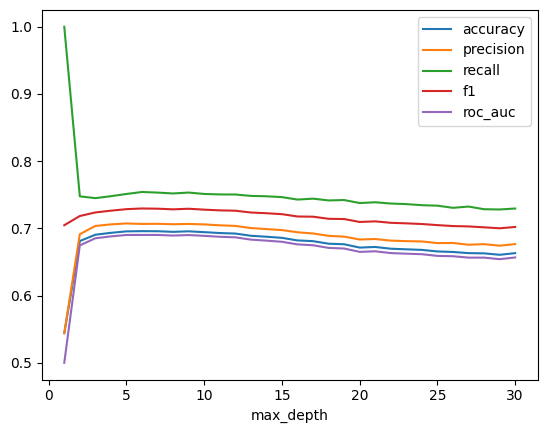

In [75]:
plt.plot(max_depth, accuracy_plot)
plt.plot(max_depth, precision_plot)
plt.plot(max_depth, recall_plot)
plt.plot(max_depth, f1_plot)
plt.plot(max_depth, roc_auc_plot)

plt.legend(["accuracy", "precision", "recall", "f1", "roc_auc"], loc = "best")

plt.xlabel("max_depth")

plt.show()

In [76]:
metrics_GBT = {
    "max_depth": [a for a, _ in accuracy],
    "accuracy": [a for _, a in accuracy],
    "precision": [a for _, a in precision],
    "recall": [a for _, a in recall],
    "f1": [a for _, a in f1],
    "roc_auc": [a for _, a in roc_auc],
}


In [82]:
metrics_GBT_df = pd.DataFrame(metrics_GBT)

,max_depth,accuracy,precision,recall,f1,roc_auc
0,1,0.544045,0.544045,1.000000,0.704701,0.500000
1,2,0.681137,0.691371,0.747658,0.718414,0.674711
2,3,0.690558,0.703642,0.744994,0.723728,0.685300
3,4,0.693372,0.705951,0.747924,0.726332,0.688103
4,5,0.695559,0.707357,0.751188,0.728614,0.690185
5,6,0.695885,0.706598,0.754163,0.729606,0.690255
6,7,0.695776,0.706819,0.753253,0.729297,0.690224
7,8,0.694834,0.706169,0.751965,0.728348,0.689315
8,9,0.695631,0.706625,0.753297,0.729215,0.690061
9,10,0.694399,0.705923,0.751232,0.727873,0.688909


In [83]:
metrics_GBT_df.to_csv("prediction_data/gbt_maxdepth_test.csv", index = False)

#### Using a subset of features

In [ ]:
# train the model using a subset of features according to variable importance 

# using "MEAN_DECREASE_IN_ACCURACY", "MEAN_DECREASE_IN_AUC_2_VS_OTHERS", and "MEAN_DECREASE_IN_PRAUC_2_VS_OTHERS" 
# to explore which features would be productive to prune

In [18]:
# tfdf.keras.FeatureUsage(name = "channelType", semantic = tfdf.keras.FeatureSemantic.CATEGORICAL),

all_features = [
    tfdf.keras.FeatureUsage(name = "cnt_courses_in_specialization", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "specialization_domain", semantic = tfdf.keras.FeatureSemantic.CATEGORICAL),
#     tfdf.keras.FeatureUsage(name = "is_professional_certificate", semantic = tfdf.keras.FeatureSemantic.CATEGORICAL),
    tfdf.keras.FeatureUsage(name = "is_gateway_certificate", semantic = tfdf.keras.FeatureSemantic.CATEGORICAL),
    tfdf.keras.FeatureUsage(name = "learner_days_since_registration", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "learner_country_group", semantic = tfdf.keras.FeatureSemantic.CATEGORICAL),
    tfdf.keras.FeatureUsage(name = "learner_gender", semantic = tfdf.keras.FeatureSemantic.CATEGORICAL),
    tfdf.keras.FeatureUsage(name = "learner_cnt_other_courses_active", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "learner_cnt_other_courses_paid_active", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "learner_cnt_other_courses_items_completed", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "learner_cnt_other_courses_paid_items_completed", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "learner_cnt_other_transactions_past", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "learner_other_revenue", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "subscription_period_order", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "days_since_last_payment", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "days_til_next_payment_due", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "cnt_enrollments_started_before_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "cnt_enrollments_completed_before_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "cnt_enrollments_active_before_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "cnt_items_completed_before_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "cnt_graded_items_completed_before_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "is_subscription_started_with_free_trial", semantic = tfdf.keras.FeatureSemantic.CATEGORICAL),
    tfdf.keras.FeatureUsage(name = "cnt_enrollments_started_during_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "cnt_enrollments_completed_during_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
#     tfdf.keras.FeatureUsage(name = "cnt_enrollments_active_during_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "cnt_items_completed_during_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "cnt_graded_items_completed_during_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "is_active_capstone_during_pay_period", semantic = tfdf.keras.FeatureSemantic.CATEGORICAL),
    tfdf.keras.FeatureUsage(name = "sum_hours_learning_before_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "sum_hours_learning_during_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
#     tfdf.keras.FeatureUsage(name = "cnt_days_active_before_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
#     tfdf.keras.FeatureUsage(name = "cnt_days_active_during_payment_period", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
    tfdf.keras.FeatureUsage(name = "cnt_days_since_last_activity", semantic = tfdf.keras.FeatureSemantic.NUMERICAL),
]

In [19]:
gbt_model = trainGBTModel(train_ds, val_ds, n_trees = 300, max_depth = 6)

[WARNING 24-05-06 14:27:21.3138 EDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-06 14:27:21.3148 EDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-06 14:27:21.3148 EDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(82791, shape=(), dtype=int32)


[INFO 24-05-06 14:28:46.5367 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpz21uw52k/model/ with prefix 31af09fa1cba488f
[INFO 24-05-06 14:28:46.5740 EDT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-05-06 14:28:46.5758 EDT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-06 14:28:46.5758 EDT kernel.cc:1061] Use fast generic engine


In [20]:
gbt_model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (29):
	cnt_courses_in_specialization
	cnt_days_since_last_activity
	cnt_enrollments_active_before_payment_period
	cnt_enrollments_completed_before_payment_period
	cnt_enrollments_completed_during_payment_period
	cnt_enrollments_started_before_payment_period
	cnt_enrollments_started_during_payment_period
	cnt_graded_items_completed_before_payment_period
	cnt_graded_items_completed_during_payment_period
	cnt_items_completed_before_payment_period
	cnt_items_completed_during_payment_period
	days_since_last_payment
	days_til_next_payment_due
	is_active_capstone_during_pay_period
	i

In [21]:
computeMetrics(gbt_model, val_ds, label)

83/83 [==============================] - 3s 31ms/step


{'accuracy': 0.6955586959935258,
 'precision': 0.7063903281519862,
 'recall': 0.7536743483859509,
 'f1': 0.7292666945939269,
 'roc_auc': 0.6899448061832268}

In [27]:
computeMetrics(gbt_model, val_ds, label)

83/83 [==============================] - 3s 41ms/step


{'accuracy': 0.6953050452343854,
 'precision': 0.7059960913135681,
 'recall': 0.7538963633941654,
 'f1': 0.7291604036933648,
 'roc_auc': 0.6896452067838399}